<a href="https://colab.research.google.com/github/Twilight1029/Python-for-Data-Analysis/blob/main/CH10_Data_Aggregation_and_Group_Operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH10 Data Aggregation and Group Operations

## Obejctive
* Split a pandas object into pieces using one or more keys (in the form of functions, arrays, or DataFrame column names)
* Calculate group summary statistics, like count, mean, or standard deviation, or a
user-defined function
* Apply within-group transformations or other manipulations, like normalization,
linear regression, rank, or subset selection
* Compute pivot tables and cross-tabulations
* Perform quantile analysis and other statistical group analyses

## 10.1 GroupBy Mechanics

A DataFrame can be grouped on its rows (axis=0) or its columns (axis=1). Once this is done, a function is applied to each group, producing a new value.



In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.DataFrame({'key1' : ['a', 'b', 'b', 'b', 'a'],
                   'key2' : ['one' , 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [ ]:
df

,key1,key2,data1,data2
0,a,one,-0.289075,0.709497
1,b,two,0.157164,0.017929
2,b,one,1.114404,-1.197678
3,b,two,-0.191052,-0.785540
4,a,one,0.457486,-0.496527


In [ ]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [ ]:
grouped.mean()

key1
a    0.084206
b    0.360172
Name: data1, dtype: float64

In [ ]:
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
key1,,,,,,,,
a,2.0,0.084206,0.527898,-0.289075,-0.102434,0.084206,0.270846,0.457486
b,3.0,0.360172,0.675990,-0.191052,-0.016944,0.157164,0.635784,1.114404


**Multiple groupby, we'd get a hierarchical index**

In [ ]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.084206
b     one     1.114404
      two    -0.016944
Name: data1, dtype: float64

In [ ]:
means.unstack()

key2,one,two
key1,,
a,0.084206,NaN
b,1.114404,-0.016944


**Group keys can be any arrays of the right length**

In [ ]:
df['data1']

0   -0.289075
1    0.157164
2    1.114404
3   -0.191052
4    0.457486
Name: data1, dtype: float64

In [ ]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.157164
            2006    1.114404
Ohio        2005   -0.240063
            2006    0.457486
Name: data1, dtype: float64

**You can pass the column names as the group keys**

* We don't have 'key2' in here, it's because key2 is not numeric data, it is said to be a **nuisance column**, which is therefore excluded from the result. By default, all of the numeric columns are aggretated.

In [ ]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.084206,0.106485
b,0.360172,-0.655096


In [ ]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.084206  0.106485
b    one   1.114404 -1.197678
     two  -0.016944 -0.383806

**size(), returns a Series containing group sizes**

In [ ]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
b     one     1
      two     2
dtype: int64

Take note that any missing values in a group key will be excluded from the result.

### Iterating Over Groups

The GroupBy object supports iteration, generating a sequence of 2-tuples containing the group name along with the chunk of data.

In [ ]:
# it is so cool! just like unstack
for name, group in df.groupby('key1'):
  print(name)
  print(group)

a
  key1 key2     data1     data2
0    a  one -0.289075  0.709497
4    a  one  0.457486 -0.496527
b
  key1 key2     data1     data2
1    b  two  0.157164  0.017929
2    b  one  1.114404 -1.197678
3    b  two -0.191052 -0.785540


**If we have multiple keys, the first element in the tuple will be a tuple of key values**

In [ ]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
  print((k1, k2))
  print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -0.289075  0.709497
4    a  one  0.457486 -0.496527
('b', 'one')
  key1 key2     data1     data2
2    b  one  1.114404 -1.197678
('b', 'two')
  key1 key2     data1     data2
1    b  two  0.157164  0.017929
3    b  two -0.191052 -0.785540


**Computing a dict of the data pieces as a one-liner:**

In [ ]:
pieces = dict(list(df.groupby('key1')))

In [ ]:
pieces['b']

,key1,key2,data1,data2
1,b,two,0.157164,0.017929
2,b,one,1.114404,-1.197678
3,b,two,-0.191052,-0.785540


In [ ]:
pieces

{'a':   key1 key2     data1     data2
 0    a  one -0.289075  0.709497
 4    a  one  0.457486 -0.496527, 'b':   key1 key2     data1     data2
 1    b  two  0.157164  0.017929
 2    b  one  1.114404 -1.197678
 3    b  two -0.191052 -0.785540}

**By default groupby groups on axis = 0 (by rows), but you can change the default setting and group on any of the other axes**

In [ ]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [ ]:
# groupby dtypes
grouped = df.groupby(df.dtypes, axis = 1)

In [ ]:
for dtype, group in grouped:
  print(dtype)
  print(group)

float64
      data1     data2
0 -0.289075  0.709497
1  0.157164  0.017929
2  1.114404 -1.197678
3 -0.191052 -0.785540
4  0.457486 -0.496527
object
  key1 key2
0    a  one
1    b  two
2    b  one
3    b  two
4    a  one


### Selecting a column or subset of columns

* Indexing a GroupBy object created from a DataFrame with a column name or array of column names has the effect of column subsetting for aggregation.**Below are the same**

In [ ]:
# the same as below
df.groupby('key1')[['data1']].mean()  #with 2 [[]], we get a dataframe instead of a series, cool!

,data1
key1,
a,0.084206
b,0.360172


In [ ]:
# the same as above
df[['data1']].groupby(df['key1']).mean()

,data1
key1,
a,0.084206
b,0.360172


In [ ]:
# can use the first way to do filter in large datasets
df.groupby(['key1', 'key2'])[['data2']].mean() # dataframe

data2
key1 key2          
a    one   0.106485
b    one  -1.197678
     two  -0.383806

In [ ]:
df.groupby(['key1', 'key2'])['data2'].mean() # series

key1  key2
a     one     0.106485
b     one    -1.197678
      two    -0.383806
Name: data2, dtype: float64

### Grouping with Dicts and Series

In [ ]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns = ['a', 'b', 'c', 'd', 'e'],
                      index = ['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [ ]:
people.iloc[2, [1, 2]] = np.nan # add some na values

In [ ]:
people

,a,b,c,d,e
Joe,-1.220087,-0.739541,0.112199,0.839161,0.179453
Steve,0.410231,0.637381,-0.456021,-0.877757,0.271822
Wes,0.712151,NaN,NaN,-2.659453,0.728497
Jim,-1.249887,0.253152,-1.112575,-0.267370,-0.539882
Travis,0.144704,-0.984614,0.983323,-1.276237,1.172254


In [ ]:
mapping = {'a' : 'red', 'b' : 'red', 'c' : 'blue',
           'd' : 'blue', 'e' : 'red', 'f' : 'orange'}

We can pass the dict to groupby (unused gropuing keys such as 'f' are OK)

In [ ]:
by_column = people.groupby(mapping, axis = 1)

In [ ]:
by_column.sum()

,blue,red
Joe,0.951360,-1.780176
Steve,-1.333778,1.319434
Wes,-2.659453,1.440647
Jim,-1.379944,-1.536618
Travis,-0.292914,0.332344


The same functionality holds for Series, which can be viewed as a fixed-size mapping

In [ ]:
map_series = pd.Series(mapping)

In [ ]:
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [ ]:
people.groupby(map_series, axis=1).sum()

,blue,red
Joe,0.951360,-1.780176
Steve,-1.333778,1.319434
Wes,-2.659453,1.440647
Jim,-1.379944,-1.536618
Travis,-0.292914,0.332344


In [ ]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### Grouping with Functions

**Group by len()**

In [ ]:
# groupby the length of the names
people.groupby(len).sum()

,a,b,c,d,e
3,-1.757823,-0.486390,-1.000376,-2.087662,0.368067
5,0.410231,0.637381,-0.456021,-0.877757,0.271822
6,0.144704,-0.984614,0.983323,-1.276237,1.172254


Mixing functions with arrays, dicts or series is Ok, since everything gets converted to arrays internally

In [ ]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -1.220087 -0.739541  0.112199 -2.659453  0.179453
  two -1.249887  0.253152 -1.112575 -0.267370 -0.539882
5 one  0.410231  0.637381 -0.456021 -0.877757  0.271822
6 two  0.144704 -0.984614  0.983323 -1.276237  1.172254

### Group by Index Levels

For hierarchically indexed dataset, we can aggregate using levels of an axis index

In [ ]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                     [1, 3, 5, 1, 3]],
                                     names = ['cty', 'tenor'])

In [ ]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns = columns)

In [ ]:
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -0.720718  1.208200 -1.227432  0.485858  2.158476
1     -0.888651 -1.430336 -1.010734  1.031102 -0.111640
2      0.243350  0.618393 -0.168118 -0.385461  1.196724
3     -0.670196  0.506390 -1.491262  1.789055 -0.362902

To groupby level, pass the level number or name using the **level** keyword

In [ ]:
hier_df.groupby(level='cty', axis = 1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 10.2 Data Aggregation

Aggreations refer to any data transformation that produces scalar values from arrays.

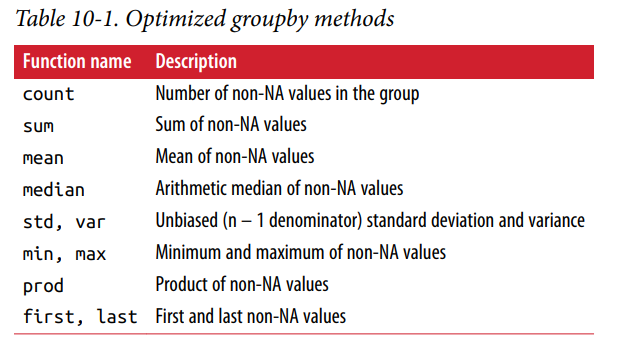

In [ ]:
df

,key1,key2,data1,data2
0,a,one,-0.289075,0.709497
1,b,two,0.157164,0.017929
2,b,one,1.114404,-1.197678
3,b,two,-0.191052,-0.785540
4,a,one,0.457486,-0.496527


In [ ]:
grouped = df.groupby('key1')

groupby calls piece.quantile() for each piece, and then assembles those results together into the result object

In [ ]:
grouped['data1'].quantile(0.9)

key1
a    0.382830
b    0.922956
Name: data1, dtype: float64

To use your own aggregation functions, pass any function that aggregates an array to the aggregate or agg method

In [ ]:
def peak_to_peak(arr):
  return arr.max() - arr.min()

In [ ]:
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,0.746561,1.206024
b,1.305456,1.215606


In [ ]:
grouped.describe()

data1                      ...     data2                    
     count      mean       std  ...       50%       75%       max
key1                            ...                              
a      2.0  0.084206  0.527898  ...  0.106485  0.407991  0.709497
b      3.0  0.360172  0.675990  ... -0.785540 -0.383806  0.017929

[2 rows x 16 columns]

### Column-Wise and Multiple Function Application

In [ ]:
tips = pd.read_csv('tips.csv')

In [ ]:
# add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [ ]:
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587


In [ ]:
# group the tips by day and smoker
grouped = tips.groupby(['day', 'smoker'])

In [ ]:
grouped_pct = grouped['tip_pct']

In [ ]:
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [ ]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

**If you pass a list of (name, function) tuples to agg, the first element of each tuple will be used as the DataFrame column names( we can think of a list of 2-tuples as an ordered mapping)**

In [ ]:
# 'foo' and 'bar' are used as column names, 'mean' and np.std are used as functions
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

In [ ]:
grouped_pct.agg([('foo', 'mean'), ('bar', 'std')])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

You can specify a list of functions to apply to all of the columns or different functions per column

In [ ]:
functions = ['count', 'mean', 'max']

In [ ]:
result = grouped['tip_pct', 'total_bill'].agg(functions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

We get a hierarchical column, we can get the same result by aggregating each column separately and using concat to glue the results together. we can get them using the column names as the keys argument.

In [ ]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

In [ ]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichug', np.var)]

In [ ]:
grouped['tip_pct', 'total_bill'].agg(ftuples)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


tip_pct             total_bill            
            Durchschnitt Abweichug Durchschnitt   Abweichug
day  smoker                                                
Fri  No         0.151650  0.000791    18.420000   25.596333
     Yes        0.174783  0.002631    16.813333   82.562438
Sat  No         0.158048  0.001581    19.661778   79.908965
     Yes        0.147906  0.003767    21.276667  101.387535
Sun  No         0.160113  0.001793    20.506667   66.099980
     Yes        0.187250  0.023757    24.120000  109.046044
Thur No         0.160298  0.001503    17.113111   59.625081
     Yes        0.163863  0.001551    19.190588   69.808518

Apply different functions to one or more columns by passing a dict to agg taht contains a mapping of column names to any of the function specifications.

In [ ]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [ ]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

### Returning Aggregated Data without Row Indexes

By default, the aggreated data comes back with an index composed from the unique group key combinatons. But we can disable this behavior by passing **as_index = False**

In [ ]:
tips.groupby(['day', 'smoker'], as_index = False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


## 10.3 Apply: General split-apply-combine

The most general-purpose GroupBy method is apply, apply splits the object being manipulated into pieces invokes the passed function on each piece, and then attempts to concatenate the pieces together

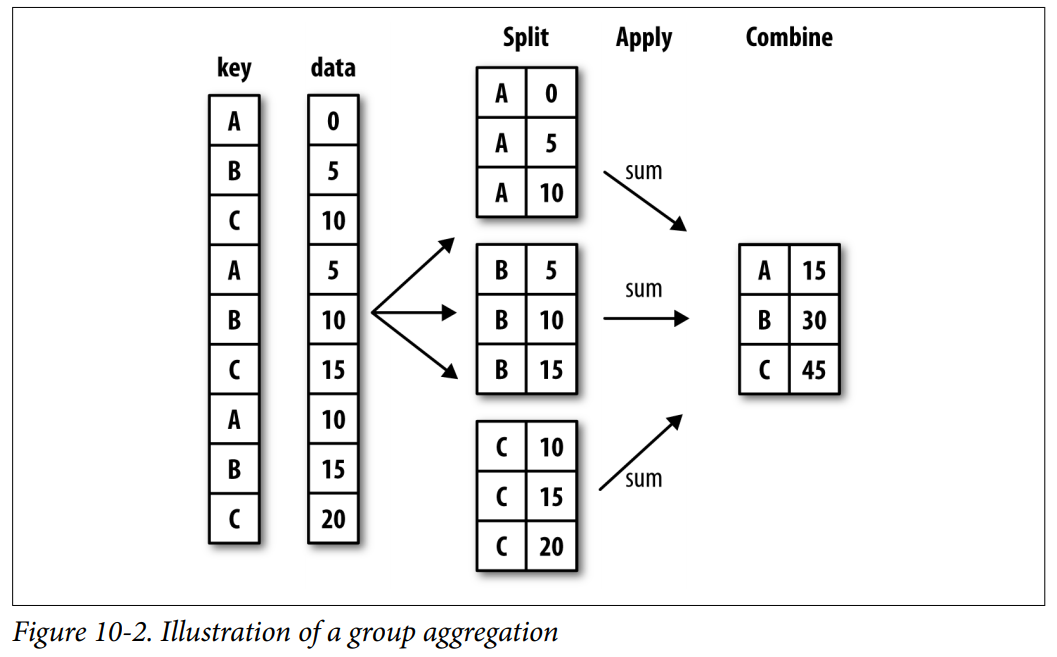

In [ ]:
# write a function to select the rows with the largest values in a particular column
def top(df, n = 5, column = 'tip_pct'):
  return df.sort_values(by = column)[-n:]

In [ ]:
top(tips, n = 6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [ ]:
tips.groupby('smoker').apply(top) # apply the top function into groupby

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

In [ ]:
# built-in function, we need to add ''
# if it's self-defined function, we don't need to add '' to call it
tips.groupby('smoker')[['total_bill']].agg(peak_to_peak) # equals to '.count()'

,total_bill
smoker,
No,41.08
Yes,47.74


In [ ]:
tips.groupby('smoker')['total_bill'].apply(peak_to_peak)

smoker
No     41.08
Yes    47.74
Name: total_bill, dtype: float64

If you pass a function to apply that takes other arguments or keywords, you can pass them in the () to specify the column you are going to apply to 

In [ ]:
tips.groupby(['smoker', 'day']).apply(top, n = 1, column = 'total_bill')

total_bill    tip     sex smoker   day    time  size   tip_pct
smoker day                                                                     
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4  0.115982

In [ ]:
tips.head(2)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542


In [ ]:
result = tips.groupby('smoker')['tip_pct'].describe()

In [ ]:
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [ ]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

In [ ]:
f = lambda x: x.describe()

In [ ]:
result = tips.groupby('smoker')[['tip_pct']].apply(f)

In [ ]:
result

tip_pct
smoker                  
No     count  151.000000
       mean     0.159328
       std      0.039910
       min      0.056797
       25%      0.136906
       50%      0.155625
       75%      0.185014
       max      0.291990
Yes    count   93.000000
       mean     0.163196
       std      0.085119
       min      0.035638
       25%      0.106771
       50%      0.153846
       75%      0.195059
       max      0.710345

Using describe() is just like a short-cut for:

f = lambda x : x.describe()

grouped.apply(f)

### Suppressing the Group Keys

You can disable indexing by the group keys using **group_keys = False**

In [ ]:
tips.groupby('smoker', group_keys = False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


### Quantile and Bucket Analysis

We can combine the **cut and qcut** for slicing data with **groupby** to perform bucket or quantile analysis

In [ ]:
frame = pd.DataFrame({'data1' : np.random.randn(1000),
                      'data2' : np.random.randn(1000)})

In [ ]:
frame.head(2)

,data1,data2
0,1.650542,0.097234
1,-0.476197,0.780843


In [ ]:
quartiles = pd.cut(frame.data1, 4)

In [ ]:
quartiles

0      (-1.728, -0.15]
1      (-1.728, -0.15]
2      (-1.728, -0.15]
3      (-1.728, -0.15]
4      (-1.728, -0.15]
            ...       
995     (1.427, 3.005]
996     (-0.15, 1.427]
997     (-0.15, 1.427]
998     (-0.15, 1.427]
999     (-0.15, 1.427]
Name: data1, Length: 1000, dtype: category
Categories (4, interval[float64]): [(-3.311, -1.728] < (-1.728, -0.15] < (-0.15, 1.427] <
                                    (1.427, 3.005]]

The categorical object returned by cut can be passed directly to groupby

In [ ]:
def get_stats(group):
  return {'min' : group.min(), 'max' : group.max(),
          'count' : group.count(), 'mean' : group.mean()}

In [ ]:
grouped = frame.data2.groupby(quartiles)

In [ ]:
grouped.apply(get_stats)

data1                  
(-3.311, -1.728]  min       -1.830666
                  max        2.547062
                  count     33.000000
                  mean      -0.031481
(-1.728, -0.15]   min       -2.817099
                  max        3.446188
                  count    393.000000
                  mean       0.046276
(-0.15, 1.427]    min       -2.965736
                  max        3.799614
                  count    490.000000
                  mean      -0.056506
(1.427, 3.005]    min       -3.557961
                  max        1.978920
                  count     84.000000
                  mean      -0.192978
Name: data2, dtype: float64

In [ ]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-3.311, -1.728]",-1.830666,2.547062,33.0,-0.031481
"(-1.728, -0.15]",-2.817099,3.446188,393.0,0.046276
"(-0.15, 1.427]",-2.965736,3.799614,490.0,-0.056506
"(1.427, 3.005]",-3.557961,1.978920,84.0,-0.192978


**cut() --> to get equal-length buckets**

**qcut() --> to get equal-size buckets**

In [ ]:
# return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels = False)

In [ ]:
grouping[grouping == 9]

0      9
9      9
16     9
26     9
33     9
      ..
978    9
980    9
986    9
988    9
990    9
Name: data1, Length: 100, dtype: int64

In [ ]:
grouped = frame.data2.groupby(grouping)

In [ ]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
0,-2.965736,2.696524,100.0,-0.006074
1,-2.664578,2.541862,100.0,0.088237
2,-2.817099,3.006331,100.0,0.012014
3,-3.557961,1.949009,100.0,-0.106809
4,-1.896425,2.415790,100.0,-0.011352
5,-2.186929,2.272041,100.0,0.011501
6,-2.334985,3.799614,100.0,-0.173782
7,-2.540192,2.261530,100.0,-0.033825
8,-2.946897,2.640539,100.0,-0.026682


### Example : Filling Missing Values with Group-specific Values

**Fill na using lambda and groupby**

In [ ]:
s = pd.Series(np.random.randn(6))

In [ ]:
s[::2] = np.nan

In [ ]:
s

0         NaN
1    0.262962
2         NaN
3    0.660490
4         NaN
5   -0.747704
dtype: float64

In [ ]:
s.fillna(s.mean())

0    0.058583
1    0.262962
2    0.058583
3    0.660490
4    0.058583
5   -0.747704
dtype: float64

You can use **apply** with **fillna** to fill value to vary by group

In [ ]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4

In [ ]:
data = pd.Series(np.random.randn(8), index = states)

In [ ]:
data

Ohio          0.293639
New York     -0.446015
Vermont      -0.257568
Florida      -1.736337
Oregon        1.192243
Nevada       -0.414103
California   -0.626024
Idaho        -0.198401
dtype: float64

In [ ]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

In [ ]:
data

Ohio          0.293639
New York     -0.446015
Vermont            NaN
Florida      -1.736337
Oregon        1.192243
Nevada             NaN
California   -0.626024
Idaho              NaN
dtype: float64

In [ ]:
data.groupby(group_key).mean()

East   -0.629571
West    0.283110
dtype: float64

In [ ]:
# we can fill the NA values using the group means
fill_mean = lambda g : g.fillna(g.mean())

In [ ]:
data.groupby(group_key).apply(fill_mean)

Ohio          0.293639
New York     -0.446015
Vermont      -0.629571
Florida      -1.736337
Oregon        1.192243
Nevada        0.283110
California   -0.626024
Idaho         0.283110
dtype: float64

In [ ]:
fill_values = {'East' : 0.5, 'West' : -1}

In [ ]:
fill_func = lambda g : g.fillna(fill_values[g.name])

In [ ]:
data.groupby(group_key).apply(fill_func)

Ohio          0.293639
New York     -0.446015
Vermont       0.500000
Florida      -1.736337
Oregon        1.192243
Nevada       -1.000000
California   -0.626024
Idaho        -1.000000
dtype: float64

### Example : Random Sampling and Permutation

Draw a random sample (with or without replacement) from a
large dataset for Monte Carlo simulation purposes or some other application. There
are a number of ways to perform the “draws”; here we use the sample method for
Series.

In [ ]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
  cards.extend(str(num) + suit for num in base_names)

deck = pd.Series(card_val, index = cards)

In [ ]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [ ]:
# drawing a hand of five cards from the deck
def draw(deck, n = 5):
  return deck.sample(n)

draw(deck)

7H     7
4S     4
AH     1
8C     8
JD    10
dtype: int64

In [ ]:
# you want 2 random cards from each suit, we can use apply
get_suit = lambda card : card[-1] # last letter is suit

deck.groupby(get_suit).apply(draw, n = 2)

C  8C      8
   10C    10
D  4D      4
   QD     10
H  QH     10
   10H    10
S  10S    10
   7S      7
dtype: int64

In [ ]:
# alternatively, we could write
deck.groupby(get_suit, group_keys=False).apply(draw, n = 2)

KC    10
AC     1
4D     4
9D     9
8H     8
2H     2
9S     9
5S     5
dtype: int64

### Example : Group Weighted Average and Correlation

In [ ]:
df = pd.DataFrame({'category' : ['a', 'a', 'a', 'a',
                                 'b', 'b', 'b', 'b'],
                   'data' : np.random.randn(8),
                   'weights' :np.random.rand(8)
                   })

In [ ]:
df

,category,data,weights
0,a,-0.909467,0.138920
1,a,-0.181832,0.027562
2,a,-0.010227,0.342048
3,a,0.958537,0.979741
4,b,1.814318,0.123795
5,b,0.246866,0.868362
6,b,-1.089615,0.502368
7,b,-0.274647,0.288526


In [ ]:
grouped = df.groupby('category')

In [ ]:
get_wavg = lambda g : np.average(g['data'], weights = g['weights'])  # 这个lambda可以直接用在object上，很神奇呀！！

In [ ]:
grouped.apply(get_wavg)

category
a    0.540403
b   -0.105245
dtype: float64

consider a financial dataset originally obtained from Yahoo! Finance containing stock price and S&P 500 index

In [ ]:
close_px = pd.read_csv('stock_px.csv', parse_dates=True, index_col= 0)

In [ ]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2214 non-null   float64
 1   MSFT    2214 non-null   float64
 2   XOM     2214 non-null   float64
 3   SPX     2214 non-null   float64
dtypes: float64(4)
memory usage: 86.5 KB


In [ ]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


Compute a DataFrame consisting of the yearly correlations of daily returns with SPX, we can create a function that computes the pairwise correlation of each column with the 'SPX' column

In [ ]:
rets = close_px.pct_change().dropna()

In [ ]:
rets

,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08,-0.020188,-0.028272,-0.004145,-0.014086
2003-01-09,0.008242,0.029094,0.021159,0.019386
...,...,...,...,...
2011-10-10,0.051406,0.026286,0.036977,0.034125
2011-10-11,0.029526,0.002227,-0.000131,0.000544
2011-10-12,0.004747,-0.001481,0.011669,0.009795
2011-10-13,0.015515,0.008160,-0.010238,-0.002974


In [ ]:
rets.index.year

Int64Index([2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003,
            ...
            2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011],
           dtype='int64', length=2213)

In [ ]:
get_year = lambda x : x.year

In [ ]:
by_year = rets.groupby(get_year)

In [ ]:
spx_corr = lambda x : x.corrwith(x['SPX'])

In [ ]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


We can also compute inter-column correlations

In [ ]:
by_year.apply(lambda g : g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### Example : Group-Wise Linear Regression

We can use groupby to perform more
complex group-wise statistical analysis, as long as the function returns a pandas
object or scalar value. For example, I can define the following regress function
(using the statsmodels econometrics library), which executes an ordinary least
squares (OLS) regression on each chunk of data:


In [ ]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
  Y = data[yvar]
  X = data[xvars]
  X['intercept'] = 1.
  result = sm.OLS(Y, X).fit()
  return result.params

In [ ]:
# run a yearly linear regression of AAPL on SPX returns
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 10.4 Pivot Tables and Cross-Tabulation

A pivot table is a data summarization tool frequently found in spreadsheet programs and other data analysis software. It **aggregates a table of data by one or more keys, arranging the dat in a rectangle with some of the group keys along the rows and some along the columns**

We can combine the pivot table and groupby function with reshape operations utilizing hierarchical indexing

In [ ]:
tips.pivot_table(index = ['day', 'smoker'])
tips.pivot_table()

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

In [ ]:
days = ['Fri', 'Sat', 'Sun', 'Thur']
smoke = ['Yes', 'No']
df_ls = []
for i in range(len(days)):
  for j in range(len(smoke)):
    df_ls.append(tips[(tips['day'] == days[i]) & (tips['smoker'] == smoke[j])])
df_selected = pd.concat(df_ls)

In [ ]:
df_selected

,total_bill,tip,sex,smoker,day,time,size,tip_pct
90,28.97,3.00,Male,Yes,Fri,Dinner,2,0.103555
92,5.75,1.00,Female,Yes,Fri,Dinner,2,0.173913
93,16.32,4.30,Female,Yes,Fri,Dinner,2,0.263480
95,40.17,4.73,Male,Yes,Fri,Dinner,4,0.117750
96,27.28,4.00,Male,Yes,Fri,Dinner,2,0.146628
...,...,...,...,...,...,...,...,...
147,11.87,1.63,Female,No,Thur,Lunch,2,0.137321
148,9.78,1.73,Male,No,Thur,Lunch,2,0.176892
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
195,7.56,1.44,Male,No,Thur,Lunch,2,0.190476


In [ ]:
df_ls

[     total_bill   tip     sex smoker  day    time  size   tip_pct
 90        28.97  3.00    Male    Yes  Fri  Dinner     2  0.103555
 92         5.75  1.00  Female    Yes  Fri  Dinner     2  0.173913
 93        16.32  4.30  Female    Yes  Fri  Dinner     2  0.263480
 95        40.17  4.73    Male    Yes  Fri  Dinner     4  0.117750
 96        27.28  4.00    Male    Yes  Fri  Dinner     2  0.146628
 97        12.03  1.50    Male    Yes  Fri  Dinner     2  0.124688
 98        21.01  3.00    Male    Yes  Fri  Dinner     2  0.142789
 100       11.35  2.50  Female    Yes  Fri  Dinner     2  0.220264
 101       15.38  3.00  Female    Yes  Fri  Dinner     2  0.195059
 220       12.16  2.20    Male    Yes  Fri   Lunch     2  0.180921
 221       13.42  3.48  Female    Yes  Fri   Lunch     2  0.259314
 222        8.58  1.92    Male    Yes  Fri   Lunch     1  0.223776
 224       13.42  1.58    Male    Yes  Fri   Lunch     2  0.117735
 225       16.27  2.50  Female    Yes  Fri   Lunch     2  0.15

In [ ]:
df_selected.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
90,28.97,3.00,Male,Yes,Fri,Dinner,2,0.103555
92,5.75,1.00,Female,Yes,Fri,Dinner,2,0.173913
93,16.32,4.30,Female,Yes,Fri,Dinner,2,0.263480
95,40.17,4.73,Male,Yes,Fri,Dinner,4,0.117750
96,27.28,4.00,Male,Yes,Fri,Dinner,2,0.146628


In [ ]:
tips.groupby(['day', 'smoker']).mean() # get the mean

total_bill       tip      size   tip_pct
day  smoker                                          
Fri  No       18.420000  2.812500  2.250000  0.151650
     Yes      16.813333  2.714000  2.066667  0.174783
Sat  No       19.661778  3.102889  2.555556  0.158048
     Yes      21.276667  2.875476  2.476190  0.147906
Sun  No       20.506667  3.167895  2.929825  0.160113
     Yes      24.120000  3.516842  2.578947  0.187250
Thur No       17.113111  2.673778  2.488889  0.160298
     Yes      19.190588  3.030000  2.352941  0.163863

In [ ]:
tips.pivot_table(['tip_pct', 'size'], index = ['time', 'day'],
                 columns = 'smoker')     # vlaues, index, columns

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

The All values are **means without taking into account smoker versus nonsmoker (the All columns) or any of the two levels of grouping on the rows**


In [ ]:
tips.pivot_table(['tip_pct', 'size'], index = ['time', 'day'],
                 columns = 'smoker', margins = True)  # add a All column to get the mean value

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [ ]:
tips.pivot_table('tip_pct', index = ['time', 'smoker'], 
                 columns = 'day', aggfunc = len, margins = True) # pass a different aggfunc(count/len)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

In [ ]:
tips.pivot_table('tip_pct', index = ['time', 'size', 'smoker'], 
                 columns = 'day', aggfunc = 'mean', fill_value = 0) # pass a fill_value to fill the NAs

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

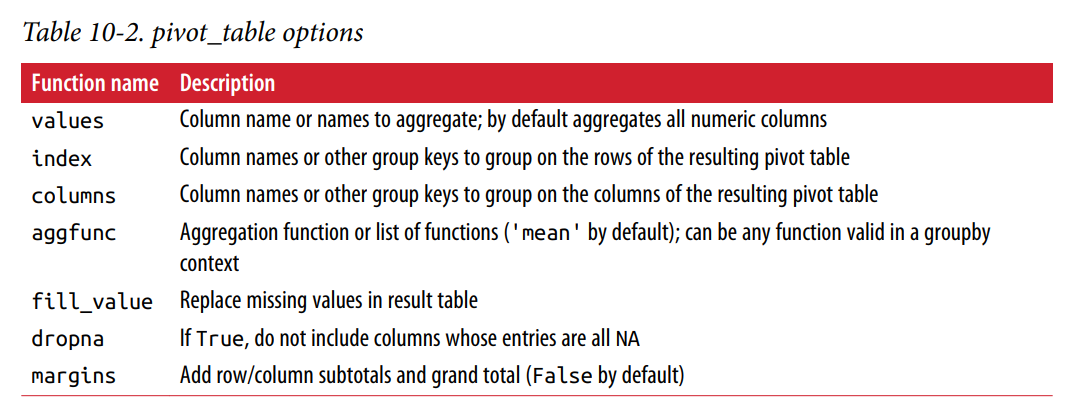

### Cross-Tabulations: Crosstab

**A cross-tabulation is a special case of a pivot table that computes group frequencies**

In [ ]:
df

,category,data,weights
0,a,-0.909467,0.138920
1,a,-0.181832,0.027562
2,a,-0.010227,0.342048
3,a,0.958537,0.979741
4,b,1.814318,0.123795
5,b,0.246866,0.868362
6,b,-1.089615,0.502368
7,b,-0.274647,0.288526


In [ ]:
pd.crosstab(df.category, df.data, margins = True)

data,-1.0896152486432813,-0.9094673947442082,-0.27464689741723164,-0.18183215242726355,-0.010227106545014821,0.24686636728670794,0.9585369454679208,1.8143175534064,All
category,,,,,,,,,
a,0,1,0,1,1,0,1,0,4
b,1,0,1,0,0,1,0,1,4
All,1,1,1,1,1,1,1,1,8


The first two arguments to crosstab can each either be **an array or Series or a list of
arrays**. As in the tips data:

In [ ]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins = True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244